<a href="https://colab.research.google.com/github/Matvezy/Body-Mesurments/blob/master/TrainExp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/AI_1050_512px_SizesRelative_Aligned

/content/gdrive/MyDrive/AI_1050_512px_SizesRelative_Aligned


In [ ]:
import time
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imutils
import matplotlib.image as mpimg
from collections import OrderedDict
from skimage import io, transform
from math import *
import xml.etree.ElementTree as ET 

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [ ]:
class Transforms():
    def __init__(self):
        pass
    
    def resize(self, image, landmarks, img_size):
        image = TF.resize(image, img_size)
        return image, landmarks

    def __call__(self, image, landmarks):
        image = Image.fromarray(image)
        image, landmarks = self.resize(image, landmarks, (512, 512))
        
        image = TF.to_tensor(image)
        #image = TF.normalize(image, [0.5], [0.5])
        return image, landmarks

In [ ]:
class FaceLandmarksDataset(Dataset):

    def __init__(self, transform=None):

        tree = ET.parse('trainSide.xml')
        root = tree.getroot()
        self.image_filenames = []
        self.landmarks = []
        self.crops = []
        self.transform = transform
        for filename in root[1]:
            self.image_filenames.append(filename.attrib['file'])
            #self.crops.append(filename[0].attrib)

            landmark = []
            for num in range(6):
                x_coordinate = int(filename[num].attrib['x'])
                y_coordinate = int(filename[num].attrib['y'])
                landmark.append([x_coordinate, y_coordinate])
            self.landmarks.append(landmark)

        self.landmarks = np.array(self.landmarks).astype('float32')     

        assert len(self.image_filenames) == len(self.landmarks)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        image = cv2.imread(self.image_filenames[index], 0)
        landmarks = self.landmarks[index]
        if self.transform:
            image, landmarks = self.transform(image, landmarks)

        return image, landmarks

dataset = FaceLandmarksDataset(Transforms())

['AI_1050_512px_SizesRelative_Aligned/1/Side.png', 'AI_1050_512px_SizesRelative_Aligned/2/Side.png', 'AI_1050_512px_SizesRelative_Aligned/3/Side.png', 'AI_1050_512px_SizesRelative_Aligned/4/Side.png', 'AI_1050_512px_SizesRelative_Aligned/5/Side.png', 'AI_1050_512px_SizesRelative_Aligned/6/Side.png', 'AI_1050_512px_SizesRelative_Aligned/7/Side.png', 'AI_1050_512px_SizesRelative_Aligned/8/Side.png', 'AI_1050_512px_SizesRelative_Aligned/9/Side.png', 'AI_1050_512px_SizesRelative_Aligned/10/Side.png', 'AI_1050_512px_SizesRelative_Aligned/11/Side.png', 'AI_1050_512px_SizesRelative_Aligned/12/Side.png', 'AI_1050_512px_SizesRelative_Aligned/13/Side.png', 'AI_1050_512px_SizesRelative_Aligned/14/Side.png', 'AI_1050_512px_SizesRelative_Aligned/15/Side.png', 'AI_1050_512px_SizesRelative_Aligned/16/Side.png', 'AI_1050_512px_SizesRelative_Aligned/17/Side.png', 'AI_1050_512px_SizesRelative_Aligned/18/Side.png', 'AI_1050_512px_SizesRelative_Aligned/19/Side.png', 'AI_1050_512px_SizesRelative_Aligned/20

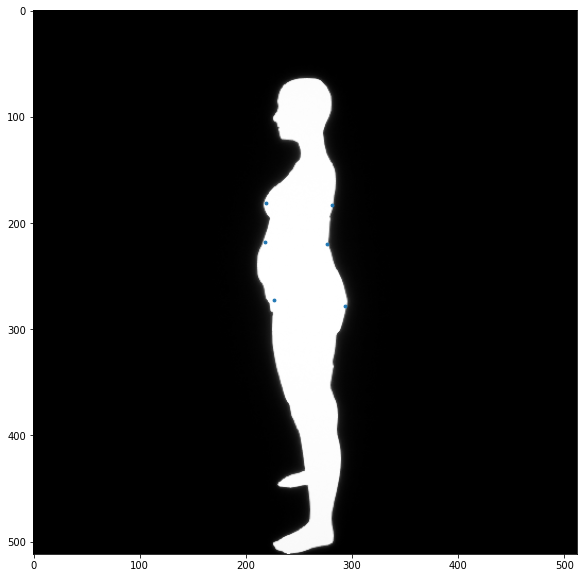

In [ ]:
print(dataset.image_filenames)
image, landmarks = dataset[1047] 
plt.figure(figsize=(10, 10))
plt.imshow(image.squeeze(), cmap='gray');
plt.scatter(landmarks[:,0], landmarks[:,1], s=8);

In [ ]:
# split the dataset into validation and test sets
len_valid_set = int(0.1*len(dataset))
len_train_set = len(dataset) - len_valid_set

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))

train_dataset , valid_dataset,  = torch.utils.data.random_split(dataset , [len_train_set, len_valid_set])

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, shuffle=True, num_workers=4)

The length of Train set is 945
The length of Valid set is 105


In [ ]:
images, landmarks = next(iter(train_loader))

print(images.shape)
print(landmarks.shape)

KeyboardInterrupt: ignored

In [ ]:
class Network(nn.Module):
    def __init__(self,num_classes=12):
        super().__init__()
        self.model_name='resnet34'
        self.model=models.resnet34()
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)
        
    def forward(self, x):
        x=self.model(x)
        return x

In [ ]:
import sys

def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))   
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
        
    sys.stdout.flush()

In [ ]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()

In [ ]:
torch.autograd.set_detect_anomaly(True)
network = Network()
network.load_state_dict(torch.load('side_landmarks6.pth')) 
network.cuda()

criterion = nn.MSELoss()
optimizer = optim.Adam(network.parameters(), lr=0.01)

loss_min = np.inf
num_epochs = 300   
start_time = time.time()
for epoch in range(1,num_epochs+1):
    
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    
    network.train()
    #network = network.load_state_dict(torch.load('body_landmarks.pth')) 
    for step in range(1,len(train_loader)+1):
        for images, landmarks in train_loader:
          if torch.cuda.is_available():
            images = images.cuda()
            landmarks = landmarks.view(landmarks.size(0),-1).cuda()  
        
        
        predictions = network(images)
        
        # clear all the gradients before calculating them
        optimizer.zero_grad()
        
        # find the loss for the current step
        loss_train_step = criterion(predictions, landmarks)
        
        # calculate the gradients
        loss_train_step.backward()
        
        # update the parameters
        optimizer.step()
        
        loss_train += loss_train_step.item()
        running_loss = loss_train/step
        
        print_overwrite(step, len(train_loader), running_loss, 'train')
        
    network.eval() 
    with torch.no_grad():
        
        for step in range(1,len(valid_loader)+1):
            
            images, landmarks = next(iter(valid_loader))
        
            images = images.cuda()
            landmarks = landmarks.view(landmarks.size(0),-1).cuda()
        
            predictions = network(images)

            # find the loss for the current step
            loss_valid_step = criterion(predictions, landmarks)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step

            print_overwrite(step, len(valid_loader), running_loss, 'valid')
    
    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)
    
    print('\n--------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}'.format(epoch, loss_train, loss_valid))
    print('--------------------------------------------------')
    
    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(network.state_dict(), 'side_landmarks6.pth') 
        print("\nMinimum Validation Loss of {:.4f} at epoch {}/{}".format(loss_min, epoch, num_epochs))
        print('Model Saved\n')
     
print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))

Valid Steps: 14/14  Loss: 13133.5543 
--------------------------------------------------
Epoch: 1  Train Loss: 271.5742  Valid Loss: 13133.5543
--------------------------------------------------

Minimum Validation Loss of 13133.5543 at epoch 1/300
Model Saved

Valid Steps: 14/14  Loss: 496.3369 
--------------------------------------------------
Epoch: 2  Train Loss: 21.9599  Valid Loss: 496.3369
--------------------------------------------------

Minimum Validation Loss of 496.3369 at epoch 2/300
Model Saved

Valid Steps: 14/14  Loss: 20.2533 
--------------------------------------------------
Epoch: 3  Train Loss: 13.6477  Valid Loss: 20.2533
--------------------------------------------------

Minimum Validation Loss of 20.2533 at epoch 3/300
Model Saved

Valid Steps: 14/14  Loss: 16.4816 
--------------------------------------------------
Epoch: 4  Train Loss: 10.6978  Valid Loss: 16.4816
--------------------------------------------------

Minimum Validation Loss of 16.4816 at epoc

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/shutil.py", line 490, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.6/shutil.py", line 488, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-q__xqtqw'


Valid Steps: 14/14  Loss: 1.8429 
--------------------------------------------------
Epoch: 198  Train Loss: 1.0784  Valid Loss: 1.8429
--------------------------------------------------
Valid Steps: 14/14  Loss: 7.5608 
--------------------------------------------------
Epoch: 199  Train Loss: 1.4245  Valid Loss: 7.5608
--------------------------------------------------
Valid Steps: 14/14  Loss: 16.8720 
--------------------------------------------------
Epoch: 200  Train Loss: 1.1175  Valid Loss: 16.8720
--------------------------------------------------
Valid Steps: 14/14  Loss: 2.2247 
--------------------------------------------------
Epoch: 201  Train Loss: 1.0063  Valid Loss: 2.2247
--------------------------------------------------
Valid Steps: 14/14  Loss: 2.6346 
--------------------------------------------------
Epoch: 202  Train Loss: 0.8799  Valid Loss: 2.6346
--------------------------------------------------
Valid Steps: 14/14  Loss: 42.1998 
----------------------------

KeyboardInterrupt: ignored

Total number of test images: 105
Elapsed Time : 22.004173755645752


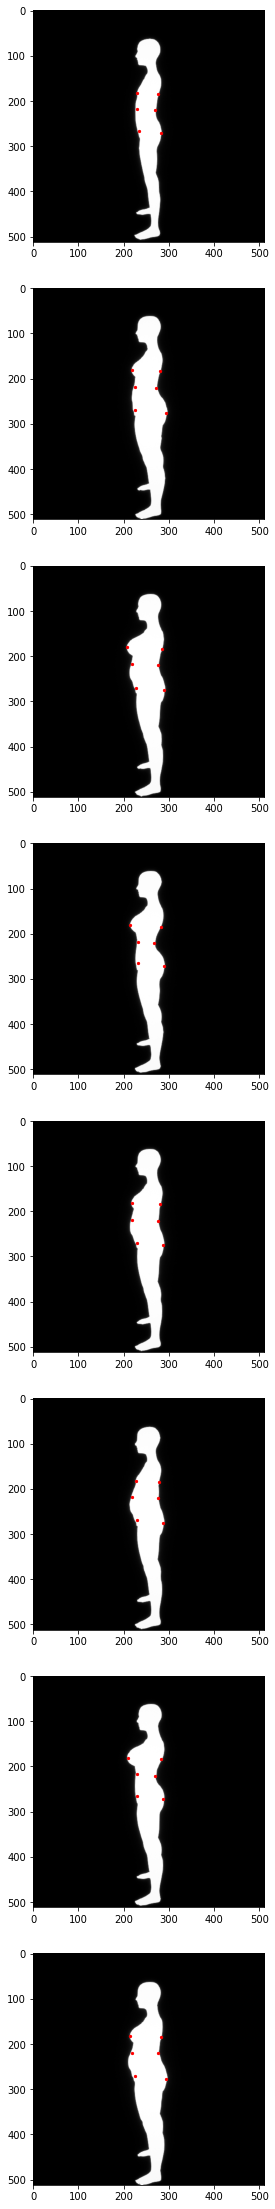

In [ ]:
start_time = time.time()

with torch.no_grad():

    best_network = Network()
    best_network.cuda()
    best_network.load_state_dict(torch.load('side_landmarks6.pth')) 
    best_network.eval()
    
    images, landmarks = next(iter(valid_loader))
    
    images = images.cuda()
    landmarks = (landmarks )

    predictions = (best_network(images).cpu())
    predictions = predictions.view(-1,6,2)
    
    plt.figure(figsize=(10,40))
    
    for img_num in range(8):
        plt.subplot(8,1,img_num+1)
        plt.imshow(images[img_num].cpu().numpy().transpose(1,2,0).squeeze(), cmap='gray')
        plt.scatter(predictions[img_num,:,0], predictions[img_num,:,1], c = 'r', s = 5)
        #plt.scatter(landmarks[img_num,:,0], landmarks[img_num,:,1], c = 'g', s = 5)

print('Total number of test images: {}'.format(len(valid_dataset)))

end_time = time.time()
print("Elapsed Time : {}".format(end_time - start_time)) 

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:280: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


torch.Size([1, 512, 512])


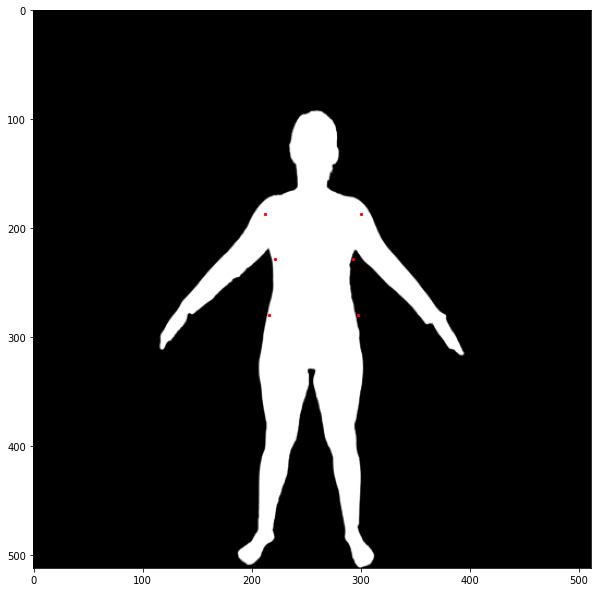

In [ ]:
from torch.autograd import Variable
imsize = 512
loader = transforms.Compose([transforms.Scale(imsize), transforms.ToTensor()])
best_network = Network()
best_network.cuda()
best_network.load_state_dict(torch.load('front_landmarks5.pth')) 
best_network.eval()
def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = cv2.imread(image_name, 0)
    image = Image.fromarray(image)
    image = TF.resize(image, (512,512))
    image = TF.to_tensor(image)
    #image = TF.normalize(image, [0.5], [0.5])  
    print(image.shape)
    image = Variable(image, requires_grad=True)
    return image.cuda()  #assumes that you're using GPU

image = image_loader("Front4.png")

predictions = (best_network(image[None, ...]).cpu())
predictions = predictions.view(-1,6,2)
predictions = predictions.detach().numpy()
    
plt.figure(figsize=(10,40))
    
plt.imshow(image.cpu().detach().numpy().transpose(1,2,0).squeeze(), cmap='gray')
plt.scatter(predictions[0,:,0], predictions[0,:,1], c = 'r', s = 5)